# Bayesian inference of the Sprinkler model using JAGS

## Introduction

This R notebook explores the Sprinkler Bayesian network, but instead of characterising the problem as a discrete Bayesian network, a more sophisticated approach is employed.

In [1]:
# Import the required libraries
library(ggplot2)
library(MCMCvis)
library(rjags)

# Ensure the figures are easy to view in the notebook
options(repr.plot.width=10, repr.plot.height=6)

Loading required package: coda

Linked to JAGS 4.3.0

Loaded modules: basemod,bugs



## Bayesian inference as a discrete Bayes net

In this section Bayesian inference is performed using JAGS where the model is the typical discrete Bayesian network.

In [14]:
# R is one-based
x = c(1,2,3)
x[1]

[1] 1

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 2
   Unobserved stochastic nodes: 2
   Total graph size: 14

Initializing model



Warning message in MCMCsummary(samp, round = 2):
"Rhat statistic cannot be calculated with one chain. NAs inserted."


,mean,sd,2.5%,50%,97.5%,Rhat,n.eff
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>
cloudy,0.98,0.13,1,1,1,NA,20000
rain,1.00,0.00,1,1,1,NA,0
sprinkler,0.00,0.00,0,0,0,NA,0
wet_grass,0.90,0.30,0,1,1,NA,20000


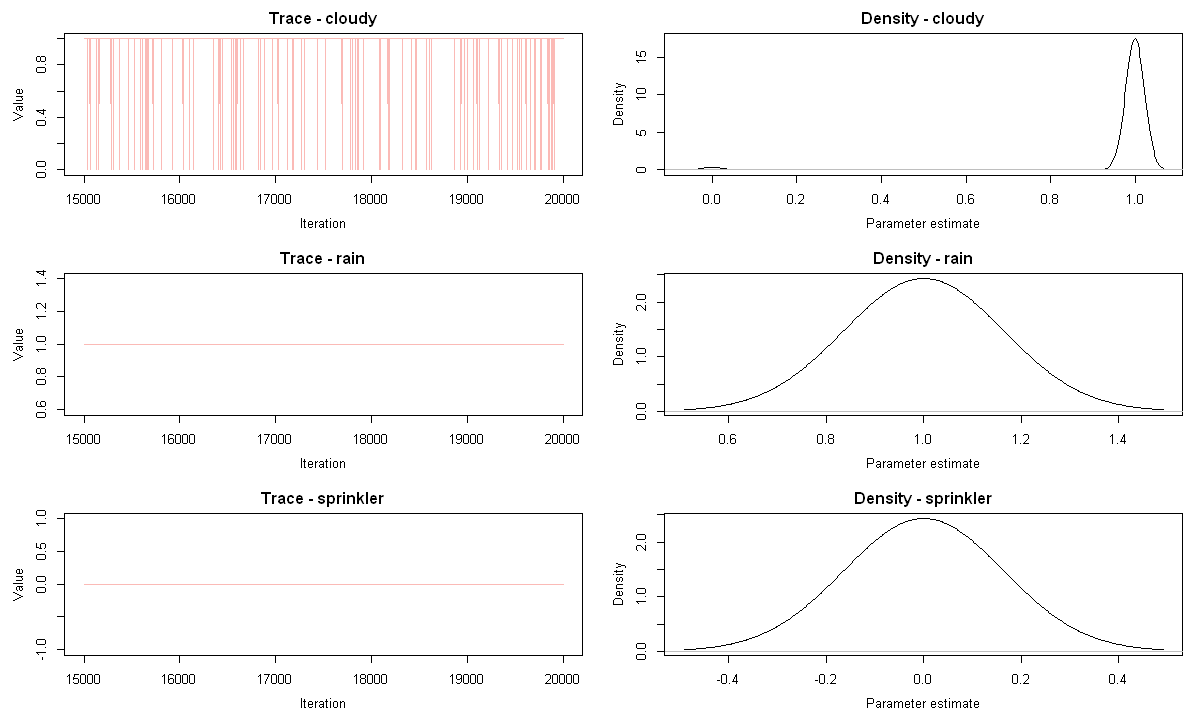

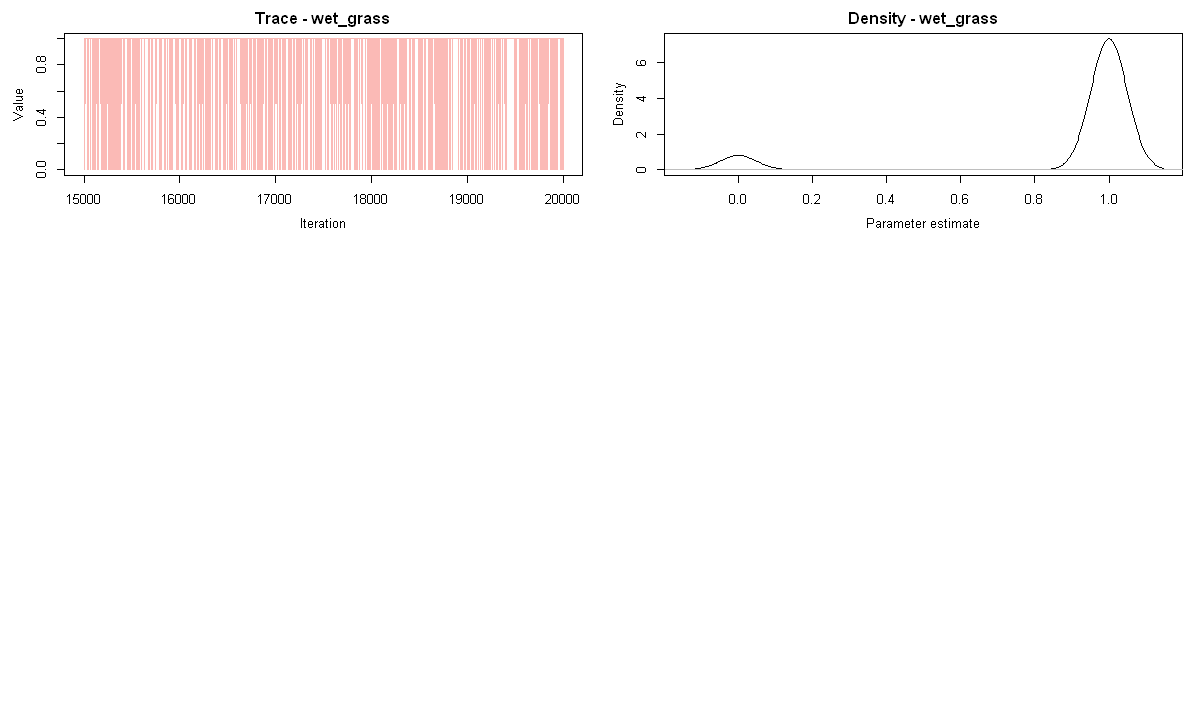

In [31]:
model_string = "
model {
    # Cloudy
    cloudy ~ dbinom(0.8, 1)

    # Sprinkler
    cpt_sprinkler[1] = 0.5  # Cloudy = false
    cpt_sprinkler[2] = 0.1  # Cloudy = true
    sprinkler ~ dbinom(cpt_sprinkler[cloudy + 1], 1)
    
    # Rain
    cpt_rain[1] = 0.1  # Cloudy = false
    cpt_rain[2] = 0.8  # Cloudy = true
    rain ~ dbinom(cpt_rain[cloudy + 1], 1)

    # Wet grass
    cpt_wet_grass[1,1] = 0.0   # Sprinkler = false, rain = false
    cpt_wet_grass[1,2] = 0.9   # Sprinkler = false, rain = true
    cpt_wet_grass[2,1] = 0.9   # Sprinkler = true, rain = false
    cpt_wet_grass[2,2] = 0.99  # Sprinkler = true, rain = true
    wet_grass ~ dbinom(cpt_wet_grass[sprinkler+1, rain+1], 1)
}
"

data = list()                     # No observations
data = list(wet_grass=1)          # Wet grass = true
data = list(sprinkler=0)          # Sprinkler = false
data = list(sprinkler=0, rain=1)  # Sprinkler = false, rain = true

model = jags.model(textConnection(model_string),
                   data = data)

update(model, 10000, progress.bar="none")

samp <- coda.samples(model, 
                     variable.names=c("cloudy", "sprinkler", "rain", "wet_grass"), 
                     n.iter=20000, progress.bar="none")

# Show a summary of the variables
MCMCsummary(samp, round = 2)

MCMCtrace(samp, 
          pdf=FALSE)

## Uniform distributions for parameters

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 0
   Unobserved stochastic nodes: 5
   Total graph size: 20

Initializing model



Warning message in MCMCsummary(samp, round = 2):
"Rhat statistic cannot be calculated with one chain. NAs inserted."


,mean,sd,2.5%,50%,97.5%,Rhat,n.eff
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>
cloudy,0.80,0.40,0,1,1,NA,20748
rain,0.66,0.47,0,1,1,NA,20702
sprinkler,0.18,0.38,0,0,1,NA,20000
wet_grass,0.70,0.46,0,1,1,NA,20473


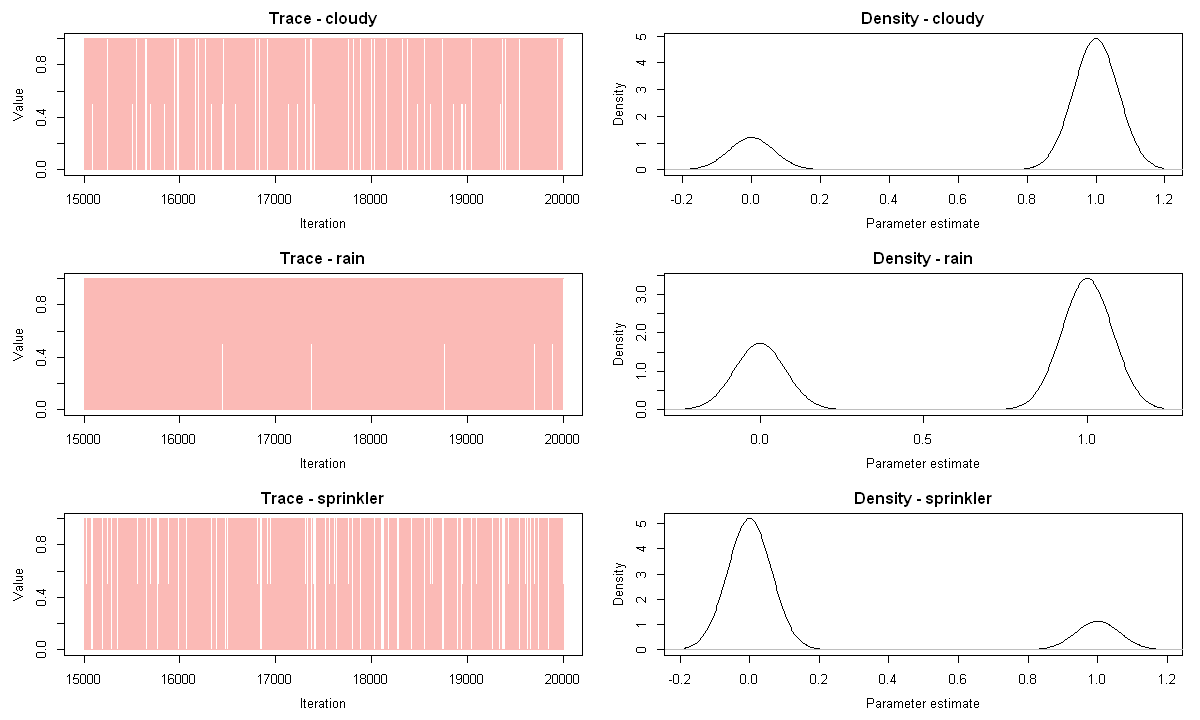

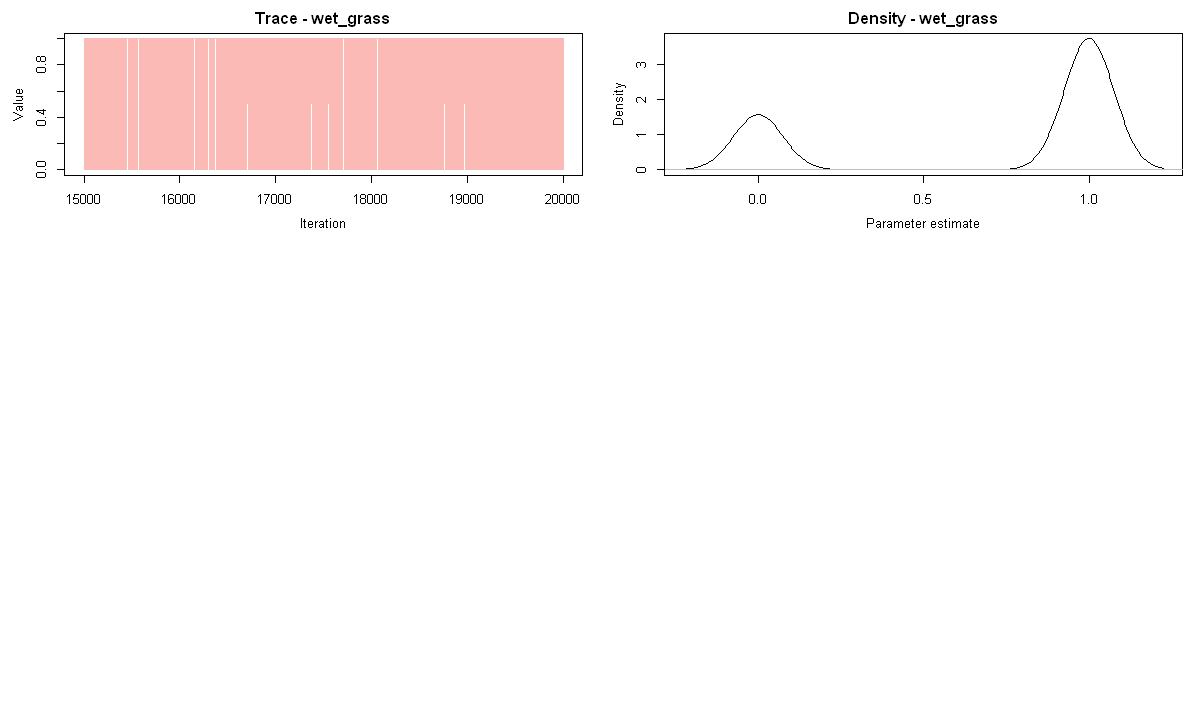

In [53]:
model_string = "
model {
    # Cloudy
    p_cloudy ~ dunif(0.75, 0.85)
    #p_cloudy = 0.4
    cloudy ~ dbinom(p_cloudy, 1)

    # Sprinkler
    cpt_sprinkler[1] = 0.5  # Cloudy = false
    cpt_sprinkler[2] = 0.1  # Cloudy = true
    sprinkler ~ dbinom(cpt_sprinkler[cloudy + 1], 1)
    
    # Rain
    cpt_rain[1] = 0.1  # Cloudy = false
    cpt_rain[2] = 0.8  # Cloudy = true
    rain ~ dbinom(cpt_rain[cloudy + 1], 1)

    # Wet grass
    cpt_wet_grass[1,1] = 0.0   # Sprinkler = false, rain = false
    cpt_wet_grass[1,2] = 0.9   # Sprinkler = false, rain = true
    cpt_wet_grass[2,1] = 0.9   # Sprinkler = true, rain = false
    cpt_wet_grass[2,2] = 0.99  # Sprinkler = true, rain = true
    wet_grass ~ dbinom(cpt_wet_grass[sprinkler+1, rain+1], 1)
}
"

data = list()                     # No observations
# data = list(wet_grass=1)          # Wet grass = true
# data = list(sprinkler=0)          # Sprinkler = false
# data = list(sprinkler=0, rain=1)  # Sprinkler = false, rain = true

model = jags.model(textConnection(model_string),
                   data = data)

update(model, 10000, progress.bar="none")

samp <- coda.samples(model, 
                     variable.names=c("cloudy", "sprinkler", "rain", "wet_grass"), 
                     n.iter=20000, progress.bar="none")

# Show a summary of the variables
MCMCsummary(samp, round = 2)

MCMCtrace(samp, 
          pdf=FALSE)

### Standard deviation of binary data

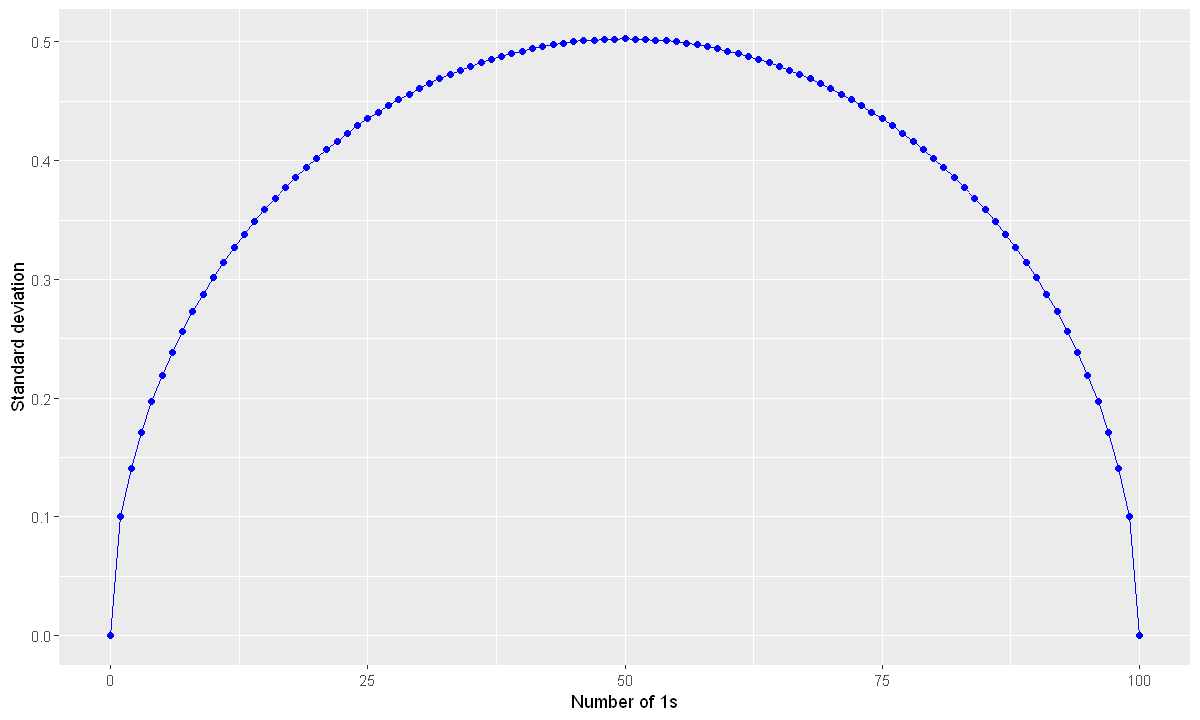

In [106]:
num_elements = 100
xvals = 0:num_elements
sds = c()

for (i in xvals) {
    x = rep(0, num_elements)
    if (i > 0) {
        x[1:i] = 1   
    }
    sds = c(sds, sd(x))
}

df = data.frame(x=xvals, y=sds)

ggplot(df, aes(x=x)) + 
    geom_point(aes(y=y), color="blue") +
    geom_line(aes(y=y), color="blue")  +
    xlab('Number of 1s') +
    ylab('Standard deviation')

## Beta distribution

The beta distribution is the conjugate prior of the bernoulli distribution.

In [41]:
estBetaParams <- function(mu, var) {
    
    # Preconditions
    stopifnot(0 <= mu) & stopifnot(mu <= 1)
    stopifnot(var < mu*(1-mu))
    
    alpha <- ((1 - mu) / var - 1 / mu) * mu ^ 2
    beta <- alpha * (1 / mu - 1)
    return(params = list(alpha = alpha, beta = beta))
}

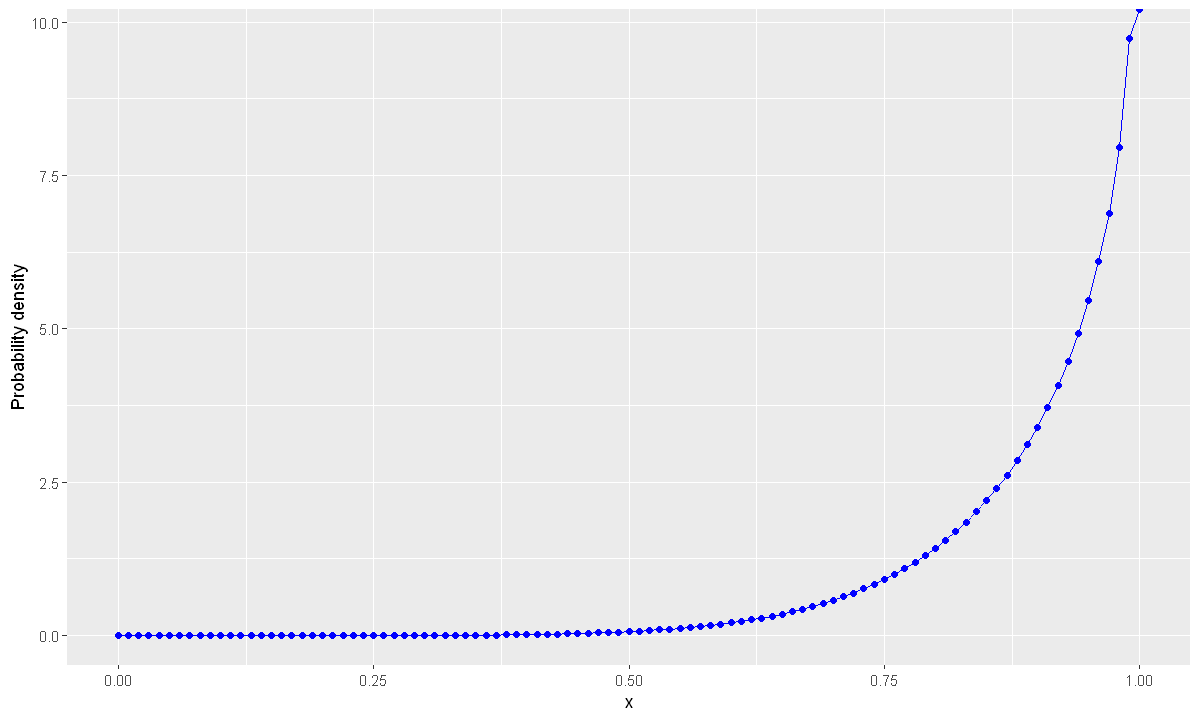

In [46]:
params = estBetaParams(0.9, 0.01)

x = seq(0, 1, by=0.01)
y = dbeta(x, params$alpha, params$beta)
df = data.frame(x=x, y=y)

ggplot(df, aes(x=x)) + 
    geom_point(aes(y=y), color="blue") +
    geom_line(aes(y=y), color="blue")  +
    xlab('x') +
    ylab('Probability density')